# Carga de paquetes

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

#Autocompletar rápido
%config IPCompleter.greedy=True

#Desactivar los warnings
import warnings
warnings.filterwarnings('ignore')

# Quitar notación científica
pd.options.display.float_format = '{:.2f}'.format

# Importación de datos

In [22]:
df = pd.read_csv('reviews_filmaffinity.csv',  sep='\|\|', header = 0, engine = 'python')
df.head()

,film_name,gender,film_avg_rate,review_rate,review_title,review_text
0,Ocho apellidos vascos,Comedia,"6,0",3.00,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,La mayor virtud de esta película es su existen...
1,Ocho apellidos vascos,Comedia,"6,0",2.00,El perro verde,"No soy un experto cinéfilo, pero pocas veces m..."
2,Ocho apellidos vascos,Comedia,"6,0",2.00,Si no eres de comer mierda... no te comas esta...,Si no eres un incondicional del humor estilo T...
3,Ocho apellidos vascos,Comedia,"6,0",2.00,Aida: The movie,"No sé qué está pasando, si la gente se deja ll..."
4,Ocho apellidos vascos,Comedia,"6,0",2.00,UN HOMBRE SOLO (Julio Iglesias 1987),"""Pero cuando amanece,y me quedo solo,siento en..."


# Calidad de datos

## Corrección de datos

Comprobamos que 'film_avg_rate' no corresponde realmente al valor que debería tener

In [23]:
df.groupby('film_name')['review_rate'].mean()[26:30]

film_name
Ocho apellidos vascos    5.48
Palmeras en la nieve     5.35
Perdiendo el norte       4.74
Perfectos desconocidos   6.38
Name: review_rate, dtype: float64

Creamos nuestro propio 'avg_rate'

In [24]:
mydict = dict(df.groupby('film_name')['review_rate'].mean())

In [25]:
def asociar_media(x):
    for peli, nota_media in mydict.items():
        if x == peli:
            resultado = round(nota_media,1)
    return(resultado)

In [26]:
df['avg_rate'] = df.film_name.transform(lambda x: asociar_media(x))

#borramos la columna film_avg_rate
df.drop(columns = 'film_avg_rate', inplace = True)
df.head()

,film_name,gender,review_rate,review_title,review_text,avg_rate
0,Ocho apellidos vascos,Comedia,3.00,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,La mayor virtud de esta película es su existen...,5.50
1,Ocho apellidos vascos,Comedia,2.00,El perro verde,"No soy un experto cinéfilo, pero pocas veces m...",5.50
2,Ocho apellidos vascos,Comedia,2.00,Si no eres de comer mierda... no te comas esta...,Si no eres un incondicional del humor estilo T...,5.50
3,Ocho apellidos vascos,Comedia,2.00,Aida: The movie,"No sé qué está pasando, si la gente se deja ll...",5.50
4,Ocho apellidos vascos,Comedia,2.00,UN HOMBRE SOLO (Julio Iglesias 1987),"""Pero cuando amanece,y me quedo solo,siento en...",5.50


In [27]:
#reordenamos las columnas
df = df[['film_name','gender','avg_rate','review_rate','review_title','review_text']]

## Nulos, duplicados y cadenas vacías

In [28]:
# Comprobamos si hay valores nulos
df.isna().sum()

film_name       0
gender          0
avg_rate        0
review_rate     2
review_title    0
review_text     0
dtype: int64

In [29]:
# Eliminamos esos dos registros
df.dropna(inplace = True)

In [30]:
# Comprobamos si hay duplicados
df.duplicated().sum()

0

In [31]:
# Comprobamos si la variable 'review_title' o 'review_text' contiene cadenas vacias
blanks_rtitle = []
blanks_rtext = []
temp = df[['review_title','review_text']].copy()

for i, rtitle, rtext in temp.itertuples():  # iteramos a través del df
    if type(rtitle) == str:                 # evitamos los valores nulos
        if rtitle.isspace():                # comprobamos si hay registros en blanco
            blanks_rtitle.append(i)         # añadimos el índice a la lista
            
    if type(rtext) == str:                  # hacemos lo mismo para la variable 'review_text'                
        if rtext.isspace():               
            blanks_rtext.append(i)

print(blanks_rtitle)
print(blanks_rtext)

[]
[]


## Definición de la target

In [32]:
#Definimos la target a través de las puntuaciones de cada película
df['target'] = df['review_rate'].apply(lambda x: 'positivo' if x > 6
                                  else('negativo' if x < 4
                                  else 'neutro'))

# Limpieza y tokenización

## Tokenización

In [33]:
import re

def quitar_tildes(palabra):
    #Definimos la versión con tildes y símbolos y la sin
    con = 'áéíóúüñÁÉÍÓÚÜÑ'
    sin = 'aeiouunAEIOUUN'
    #Creamos un traductor
    traductor = str.maketrans(con,sin)
    #Aplicamos el traductor y devolvemos la palabra limpia
    return(palabra.translate(traductor))


#Cargamos la lista de stopwords
stop = pd.read_csv('../../../00_DATASETS/stop_words_spanish.txt',names = ['termino'])
stop['limpias'] = stop.termino.apply(quitar_tildes)


# Función para eliminar stop_words
def quitar_stop_words(registro):
    for stop_word in stop.limpias.to_list():
        for word in registro:
            if word == stop_word:
                registro.remove(word)
    return(registro)


def limpiar_tokenizar(texto):
    '''
    Esta función limpia y tokeniza el texto en palabras individuales.
    El orden en el que se va limpiando el texto no es arbitrario.
    El listado de signos de puntuación se ha obtenido de: print(string.punctuation)
    y re.escape(string.punctuation)
    '''
    
    # Se convierte todo el texto a minúsculas
    nuevo_texto = texto.lower()
    # Eliminación de páginas web (palabras que empiezan por "http")
    nuevo_texto = re.sub('http\S+', ' ', nuevo_texto)
    # Eliminación de signos de puntuación
    regex = '[\\!\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~]'
    nuevo_texto = re.sub(regex , ' ', nuevo_texto)
    # Eliminación de números
    nuevo_texto = re.sub("\d+", ' ', nuevo_texto)
    # Eliminación de espacios en blanco múltiples
    nuevo_texto = re.sub("\\s+", ' ', nuevo_texto)
    # Tokenización por palabras individuales
    nuevo_texto = nuevo_texto.split(sep = ' ')
    # Eliminación de tokens con una longitud < 2
    nuevo_texto = [token for token in nuevo_texto if len(token) > 1]
    # Eliminamos las tildes/acentos de cada palabra
    nuevo_texto = [quitar_tildes(word) for word in nuevo_texto]
    # Eliminamos las stop_words del texto
    nuevo_texto = quitar_stop_words(nuevo_texto)
    
    return(nuevo_texto)

In [34]:
from tqdm import tqdm
tqdm.pandas()
df['text_cleaned'] = df['review_text'].progress_apply(lambda x: limpiar_tokenizar(x))

100%|█████████████████████████████████████| 8601/8601 [00:35<00:00, 240.92it/s]


# Análisis exploratorio

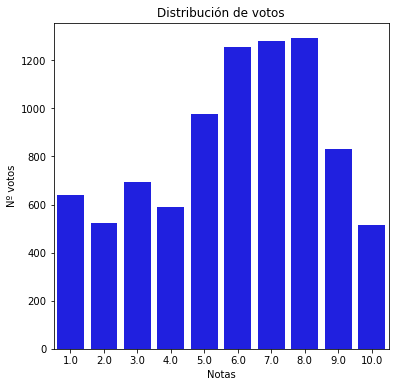

In [40]:
# Visualizamos la distribución de votos
f, ax = plt.subplots(figsize = (6,6))
sns.countplot(x = 'review_rate', color = 'b', data = df)
plt.title('Distribución de votos')
plt.xlabel('Notas')
plt.ylabel('Nº votos');

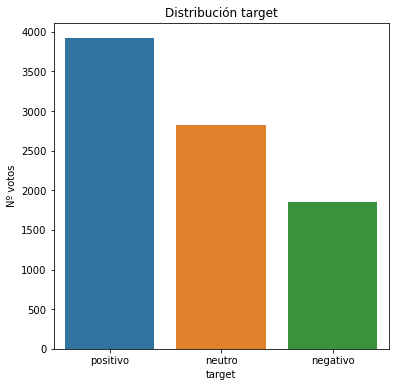

In [41]:
# Visualizamos la distribución de la target
f, ax = plt.subplots(figsize = (6,6))
sns.countplot(x = 'target', data = df, order = ['positivo','neutro','negativo'])
plt.xlabel('target')
plt.ylabel('Nº votos')
plt.title('Distribución target');

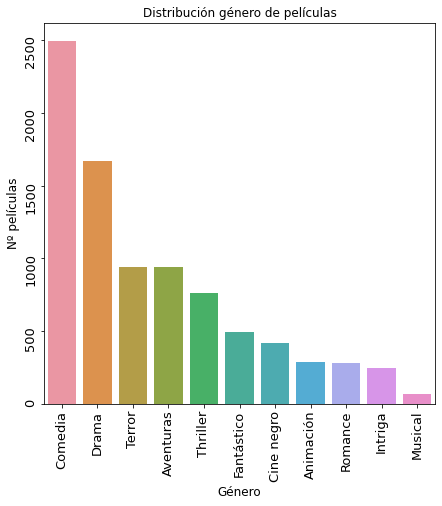

In [42]:
# Visualización de la distribución del género de películas
orden_genero = list(df.gender.value_counts().reset_index()['index'])
f, ax = plt.subplots(figsize = (7,7))
sns.countplot(x = 'gender', data = df, order = orden_genero)
ax.tick_params(axis = 'x', labelsize = 13, labelrotation = 90)
ax.tick_params(axis = 'y', labelsize = 13, labelrotation = 90)
plt.xlabel('Género', fontsize = 12)
plt.ylabel('Nº películas', fontsize = 12)
plt.title('Distribución género de películas');

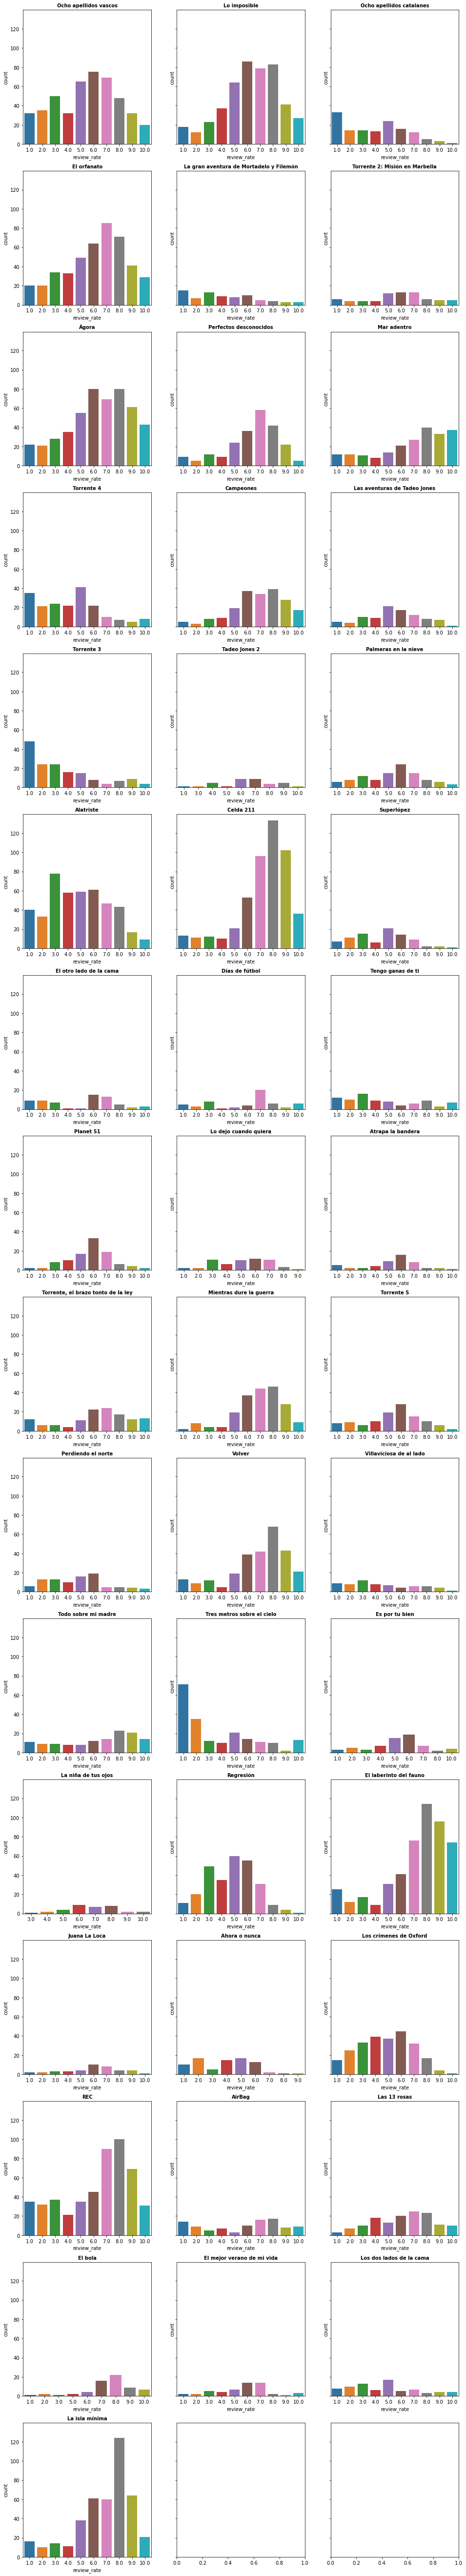

In [43]:
# Distribución de los votos por película
temp = df.copy()
from math import ceil
filas = ceil(temp.film_name.value_counts().size / 3)

# definimos el gráfico
f, ax = plt.subplots(nrows = filas, ncols = 3, figsize = (16, filas*6), sharey = True)

#Aplanamos para iterar por el gráfico como si fuera de 1 dimensión en lugar de 2
ax = ax.flat 

for cada, x in zip(temp.film_name.unique(), range(temp.film_name.value_counts().size)):
    sns.countplot(x = 'review_rate', data = temp.loc[temp.film_name == cada], ax = ax[x])
    ax[x].set_title(cada, fontsize = 10, fontweight = "bold")

## Frecuencia de palabras

In [44]:
# unnest de la columna 'r_text_cleaned' para tener una observación por fila al nivel en el que queremos nuestro df
df_tidy = df.explode(column = 'text_cleaned')
df_tidy = df_tidy.rename(columns = {'text_cleaned':'token'})
df_tidy.drop(columns = ['review_text'] , inplace = True)
df_tidy.head(3)

,film_name,gender,avg_rate,review_rate,review_title,target,token
0,Ocho apellidos vascos,Comedia,5.50,3.00,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,negativo,virtud
0,Ocho apellidos vascos,Comedia,5.50,3.00,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,negativo,pelicula
0,Ocho apellidos vascos,Comedia,5.50,3.00,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,negativo,existencia


### Palabras totales utilizadas por género

In [45]:
df_tidy.groupby('gender')['token'].count().sort_values(ascending = False)

gender
Comedia       207184
Drama         156159
Aventuras      90909
Terror         73946
Thriller       65878
Cine negro     42058
Fantástico     38327
Animación      26767
Romance        23203
Intriga        20637
Musical         3501
Name: token, dtype: int64

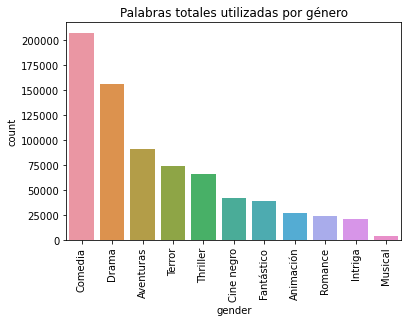

In [46]:
g = df_tidy.groupby('gender')['token'].nunique().sort_values(ascending = False)
sns.countplot(x = df_tidy.gender, data = df_tidy, order = g.index)
plt.title('Palabras totales utilizadas por género')
plt.tick_params(axis = 'x', labelrotation = 90);

### Palabras únicas utilizadas por género

In [47]:
df_tidy.groupby('gender')['token'].nunique().sort_values(ascending = False)

gender
Comedia       28192
Drama         24984
Aventuras     17827
Terror        14971
Thriller      14598
Cine negro    11176
Fantástico     9821
Animación      7940
Romance        7879
Intriga        6885
Musical        1743
Name: token, dtype: int64

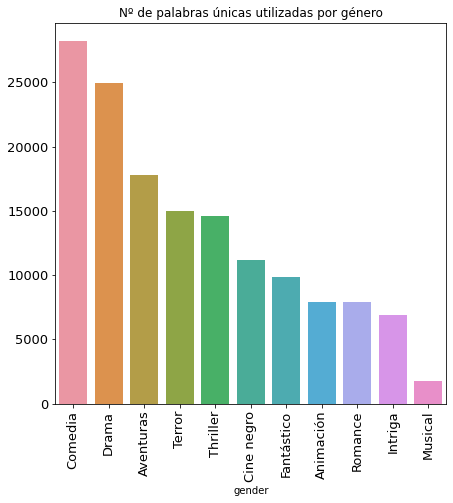

In [48]:
p = df_tidy.groupby('gender')['token'].nunique().sort_values(ascending = False)
f, ax = plt.subplots(figsize = (7,7))
sns.barplot(x = p.index, y = p.values)
ax.set_title('Nº de palabras únicas utilizadas por género')
ax.tick_params(axis = 'x', labelsize = 13, labelrotation = 90)
ax.tick_params(axis = 'y', labelsize = 13);

## Longitud media de reviews

In [49]:
temp = pd.DataFrame(df_tidy.groupby(['gender','review_title'])['token'].count().reset_index())
temp_l= temp.groupby('gender')['token'].agg(['mean','std']).sort_values('mean', ascending = False)
temp_l

,mean,std
gender,,
Cine negro,102.58,82.85
Aventuras,99.03,59.79
Drama,96.57,70.11
Animación,96.28,69.09
Thriller,88.78,67.50
Comedia,85.83,70.76
Intriga,83.89,50.42
Romance,83.77,58.40
Terror,80.46,55.86


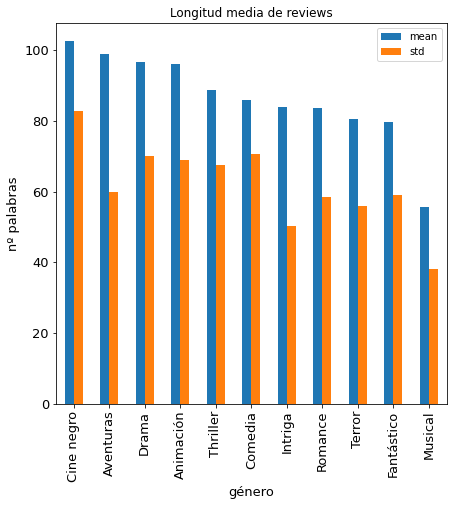

In [50]:
temp_l[['mean', 'std']].plot.bar(figsize = (7,7))
plt.title('Longitud media de reviews')
plt.tick_params(labelsize = 13)
plt.xlabel('género', fontsize = 13)
plt.ylabel('nº palabras', fontsize = 13);

## Palabras más utilizadas en los géneros Comedia y Drama

In [51]:
temp = df_tidy.groupby(['gender', 'token'])['token'].count().reset_index(name = 'count') \
    .groupby('gender').apply(lambda x: x.sort_values('count', ascending = False).head(10))
temp = temp.loc[temp['gender'].isin(['Comedia','Drama'])]
temp

gender       token  count
gender                                   
Comedia 56249  Comedia    pelicula   4401
        41814  Comedia        cine   1643
        42189  Comedia     comedia   1317
        62699  Comedia    torrente   1315
        62118  Comedia          te    997
        50477  Comedia       humor    930
        60619  Comedia      segura    873
        56588  Comedia  personajes    852
        50260  Comedia    historia    838
        56587  Comedia   personaje    821
Drama   82400    Drama    pelicula   3504
        76912    Drama    historia   1422
        69327    Drama        cine   1070
        66232    Drama   almodovar    712
        87634    Drama          te    636
        72663    Drama    director    623
        82696    Drama  personajes    574
        82403    Drama   peliculas    545
        89115    Drama        vida    533
        66385    Drama    amenabar    526

## Comparación en el uso de palabras

Palabras que se utilizan mucho en un género pero que no se usan en el otro. Haremos la comparación entre los géneros Comedia y Drama. El análisis lo podemos hacer mediante log of odds ratio de las frecuencias de cada token. En la fórmula siguiente se expresa siendo "_nk_" el número de veces que aparece el término "_k_" en las reviews de cada género y _N_ el nº total de términos de cada género.

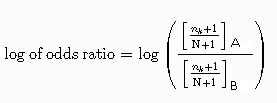

In [52]:
# Cálculo del log of odds ratio de cada palabra (Comedia vs Thriller)
# pivotamos
df_pivot = df_tidy.groupby(['gender','token'])['token'].agg(['count']).reset_index() \
    .pivot(index = 'token', columns = 'gender', values = 'count')[['Comedia','Drama']]

# despivotamos rellenandos los NaN values por cero
df_pivot = df_pivot.fillna(value = 0)
df_pivot.columns.name = None

df_unpivot = df_pivot.melt(value_name = 'n', var_name = 'gender', ignore_index = False).reset_index()

# Añadimos el total de palabras de cada género
df_unpivot = df_unpivot.merge(df_tidy.groupby('gender')['token'].count().rename('N'),
                 how = 'left',
                 on = 'gender')

# Calculo de odds y log of odds de cada palabra
df_logOdds = df_unpivot.copy()
df_logOdds['odds'] = (df_logOdds.n + 1) / (df_logOdds.N + 1)
df_logOdds = df_logOdds[['token','gender','odds']].pivot(index = 'token', columns = 'gender', values = 'odds')
df_logOdds.columns.name = None

df_logOdds['log_odds'] = np.log(df_logOdds['Comedia']/df_logOdds['Drama'])
df_logOdds['abs_log_odds'] = np.abs(df_logOdds['log_odds'])

# Si log_odds > 0, significa que la palabra tiene mayor probabilidad de ser del género de Comedia 
# porque el ratio se ha calculado como Comedia/Drama
df_logOdds['frequent_gender'] = np.where(df_logOdds['log_odds'] > 0, 'Comedia','Drama')

# Obtenemos las 10 palabras más diferenciadoras
df_logOdds.nlargest(n=10, columns = 'abs_log_odds')

,Comedia,Drama,log_odds,abs_log_odds,frequent_gender
token,,,,,
penelope,0.00,0.00,-6.02,6.02,Drama
watts,0.00,0.00,-5.82,5.82,Drama
naomi,0.00,0.00,-5.70,5.70,Drama
unamuno,0.00,0.00,-5.51,5.51,Drama
tsunami,0.00,0.00,-5.39,5.39,Drama
machi,0.00,0.00,5.38,5.38,Comedia
rovira,0.00,0.00,5.38,5.38,Comedia
mcgregor,0.00,0.00,-5.35,5.35,Drama
sampedro,0.00,0.00,-5.27,5.27,Drama


## Las 15 palabras más características de ambos géneros de comparación 

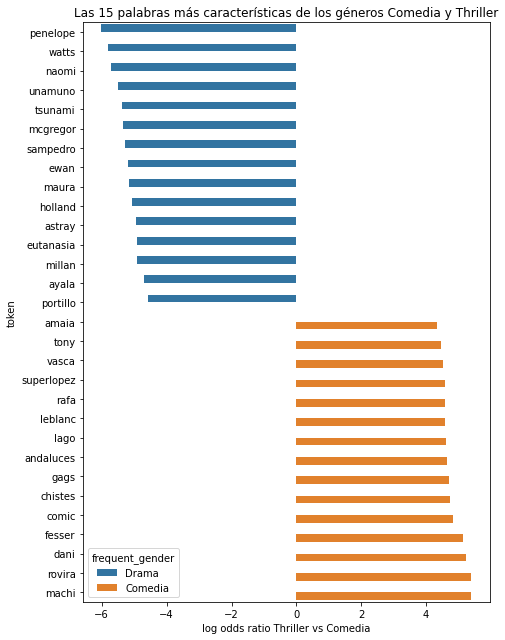

In [54]:
top_15 = df_logOdds[['log_odds', 'abs_log_odds', 'frequent_gender']] \
.groupby('frequent_gender') \
.apply(lambda x: x.nlargest(n = 15, columns = 'abs_log_odds').reset_index()) \
.reset_index(drop = True) \
.sort_values('log_odds') 

f, ax = plt.subplots(figsize = (7,9))
sns.barplot(x = 'log_odds', y = 'token', hue = 'frequent_gender', data = top_15, ax = ax)
ax.set_title('Las 15 palabras más características de los géneros Comedia y Thriller')
ax.set_xlabel('log odds ratio Thriller vs Comedia')
f.tight_layout();

# Modelo de clasificación de género

Se compararán los comentarios de películas de género "Comedia" y "Drama" que son los géneros que continene más registros para ver si a través de los comentarios el modelo puede predecir de qué género se trata.

In [55]:
datos_X = df.loc[df.gender.isin(['Comedia','Drama']), 'review_text']
datos_y = df.loc[df.gender.isin(['Comedia','Drama']), 'gender']

## Reservamos el dataset de entrenamiento y validación

In [56]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(datos_X,
                                                    datos_y,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [57]:
# comprobamos si hay algún espacio en blanco en nuestro texto de tweets
temp = df.copy()
temp = temp[['gender','review_text','text_cleaned']]

blanks = []

# (index, label, review text)
for i, género, review, texto_tokenizado in temp.itertuples():
    if review.isspace():
        blanks.append(i)
blanks

[]

In [58]:
# Verificamos que la proporción de cada grupo es similar en set de training and testing
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{'Comedia': 59.69387755102041, 'Drama': 40.30612244897959}
{'Comedia': 60.624249699879954, 'Drama': 39.375750300120046}


In [59]:
# Creación de la matriz tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizador = TfidfVectorizer(tokenizer  = limpiar_tokenizar,
                                     min_df     = 3,
                                     stop_words = stop.limpias.to_list())
tfidf_vectorizador.fit(X_train)

TfidfVectorizer(min_df=3,
                stop_words=['algun', 'alguna', 'algunas', 'alguno', 'algunos',
                            'ambos', 'ampleamos', 'ante', 'antes', 'aquel',
                            'aquellas', 'aquellos', 'aqui', 'arriba', 'atras',
                            'bajo', 'bastante', 'bien', 'cada', 'cierta',
                            'ciertas', 'cierto', 'ciertos', 'como', 'con',
                            'conseguimos', 'conseguir', 'consigo', 'consigue',
                            'consiguen', ...],
                tokenizer=<function limpiar_tokenizar at 0x000000001F6D8C10>)

In [60]:
# transformamos los documentos de test de la matriz obtenida previamente en "train"
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)

## Creamos el pipe y el diccionario de algoritmos, parámetros y valores a testar

Como comprobaremos más tarde la regresión logística nos ofrece muy buenos resultados por lo que no probaremos otros algoritmos

In [61]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
pipe = Pipeline([('algoritmo',LogisticRegression())])

grid = {'algoritmo': [LogisticRegression()],
         'algoritmo__n_jobs': [-1],
         'algoritmo__solver': ['saga'],
         'algoritmo__penalty': ['elasticnet', 'l1', 'l2', 'none'],
         'algoritmo__C': [0,0.25,0.5,0.75,1]}

## Aplicamos random search

In [62]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = pipe,
                                   param_distributions = grid, 
                                   n_iter = 5, 
                                   cv = 3, 
                                   scoring = 'roc_auc', 
                                   verbose = 1,
                                   n_jobs = -1)
    

modelo = random_search.fit(X = tfidf_train, y = y_train)

pd.DataFrame(random_search.cv_results_).sort_values(by = 'rank_test_score') \
    [['param_algoritmo__penalty', 'param_algoritmo',
      'param_algoritmo__C','param_algoritmo', 'mean_test_score','std_test_score','rank_test_score']]

Fitting 3 folds for each of 5 candidates, totalling 15 fits


,param_algoritmo__penalty,param_algoritmo,param_algoritmo__C,param_algoritmo,mean_test_score,std_test_score,rank_test_score
0,none,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",0,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",1.00,0.00,1
2,none,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",1,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",1.00,0.00,2
4,l2,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",0.25,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",1.00,0.00,3
1,l1,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",0,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",NaN,NaN,4
3,elasticnet,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",0.50,"LogisticRegression(C=0, n_jobs=-1, penalty='no...",NaN,NaN,5


## Predecir sobre validación 

In [63]:
pred = modelo.best_estimator_.predict_proba(tfidf_test)[:, 1]

## Evaluar sobre validación

In [64]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, pred)

0.9968968848104323

# Análisis de sentimiento

Generamos un modelo que intente predecir si el comentario (review) es positivo (review_rate > 5) o por el contrario
es negativo (review_rate > 5)

In [65]:
# Definimos una target binaria
df['target'] = df['review_rate'].apply(lambda x: 1 if x > 5 else 0)

In [66]:
datos_X = df['review_text']
datos_y = df['target']

## Reservamos el dataset de entrenamiento y validación

In [67]:
from sklearn.model_selection import train_test_split  
X_train, X_test, y_train, y_test = train_test_split(datos_X,
                                                    datos_y,
                                                    test_size = 0.2,
                                                    random_state = 0)

In [68]:
# Verificamos que la proporción de cada grupo es similar en set de training and testing
value, counts = np.unique(y_train, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))
value, counts = np.unique(y_test, return_counts=True)
print(dict(zip(value, 100 * counts / sum(counts))))

{0: 40.218023255813954, 1: 59.781976744186046}
{0: 38.233585124927366, 1: 61.766414875072634}


In [69]:
# Creación de la matriz tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizador = TfidfVectorizer(tokenizer  = limpiar_tokenizar,
                                     min_df     = 3,
                                     stop_words = None)
tfidf_vectorizador.fit(X_train)

TfidfVectorizer(min_df=3,
                tokenizer=<function limpiar_tokenizar at 0x000000001F6D8C10>)

In [70]:
# transformamos los documentos de test de la matriz obtenida previamente en "train"
tfidf_train = tfidf_vectorizador.transform(X_train)
tfidf_test  = tfidf_vectorizador.transform(X_test)

## Creamos el pipe y el diccionario de algoritmos, parámetros y valores a testar

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
pipe = Pipeline([('algoritmo',LogisticRegression())])

grid = [{'algoritmo': [LogisticRegression()],
         'algoritmo__n_jobs': [-1],
         'algoritmo__solver': ['saga'],
         'algoritmo__penalty': ['elasticnet', 'l1', 'l2', 'none'],
         'algoritmo__C': [0,0.25,0.5,0.75,1]},
        
        {'algoritmo': [RandomForestClassifier()],
         'algoritmo__n_jobs': [-1],
         'algoritmo__max_depth': [5,10,15],
         'algoritmo__n_estimators': [50,100,200]}]
        


## Aplicamos random search

In [81]:
from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(estimator = pipe,
                                   param_distributions = grid, 
                                   n_iter = 5, 
                                   cv = 3, 
                                   scoring = 'roc_auc', 
                                   verbose = 1,
                                   n_jobs = -1)
    

modelo = random_search.fit(X = tfidf_train, y = y_train)

pd.DataFrame(random_search.cv_results_).sort_values(by = 'rank_test_score') \
    [['param_algoritmo__penalty', 'param_algoritmo',
      'param_algoritmo__C','param_algoritmo', 'mean_test_score','std_test_score','rank_test_score']]

Fitting 3 folds for each of 5 candidates, totalling 15 fits


,param_algoritmo__penalty,param_algoritmo,param_algoritmo__C,param_algoritmo,mean_test_score,std_test_score,rank_test_score
1,l2,"LogisticRegression(C=1, n_jobs=-1, solver='saga')",1,"LogisticRegression(C=1, n_jobs=-1, solver='saga')",0.88,0.01,1
3,l2,"LogisticRegression(C=1, n_jobs=-1, solver='saga')",0.50,"LogisticRegression(C=1, n_jobs=-1, solver='saga')",0.87,0.01,2
0,NaN,RandomForestClassifier(),NaN,RandomForestClassifier(),0.83,0.01,3
4,l1,"LogisticRegression(C=1, n_jobs=-1, solver='saga')",0.75,"LogisticRegression(C=1, n_jobs=-1, solver='saga')",0.82,0.01,4
2,NaN,RandomForestClassifier(),NaN,RandomForestClassifier(),0.80,0.01,5


## Predecir sobre validación

In [82]:
pred = modelo.best_estimator_.predict_proba(tfidf_test)[:, 1]

## Evaluar sobre validación

In [83]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, pred)

0.8909420776777314

## Conclusión

El módelo no es solo útil si no que nos ofrece muy buena capacidad predictiva

# Análisis de sentimiento2

Analizamos el sentimiento de un texto considerando su sentimiento como la suma de los sentimientos de cada una de las palabras que lo forman. Para ello disponemos de un diccionario para asociar cada palabra con un nivel de sentimiento (sentiment lexicon).

En nuestro diccionario las palabras estarán clasificadas como positivas (1) o negativas (0)

In [155]:
lexicon = pd.read_csv('subjectivity.csv')
lexicon = lexicon[['termino','polaridad']]
lexicon['valor'] = np.where(lexicon.polaridad == 'positive', 1, -1)
lexicon.head(3)

,termino,polaridad,valor
0,abandonar,negative,-1
1,aberrante,negative,-1
2,abominación,negative,-1


In [156]:
# le quitamos las tildes a nuestro diccionario
lexicon['termino'] = lexicon['termino'].apply(lambda x: quitar_tildes(x))
lexicon.head(3)

,termino,polaridad,valor
0,abandonar,negative,-1
1,aberrante,negative,-1
2,abominacion,negative,-1


## Sentimiento promedio de cada review

In [157]:
# Simplificamos nuestra target en comentarios positivos y negativos
df_tidy['target'] = np.where(df_tidy['review_rate'] >= 5, 'positivo', 'negativo')
df_tidy.head(3)

,film_name,gender,avg_rate,review_rate,review_title,target,token
0,Ocho apellidos vascos,Comedia,5.50,3.00,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,negativo,virtud
0,Ocho apellidos vascos,Comedia,5.50,3.00,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,negativo,pelicula
0,Ocho apellidos vascos,Comedia,5.50,3.00,OCHO APELLIDOS VASCOS...Y NINGÚN NOMBRE PROPIO,negativo,existencia


In [158]:
df_sentimientos = pd.merge(left = df_tidy,
                           right = lexicon,
                           left_on = 'token',
                           right_on = 'termino',
                           how = 'inner')

df_sentimientos.drop(columns = ['termino','polaridad'], inplace = True)


df_sentimientos = df_sentimientos[['film_name','review_title','target','valor']] \
                    .groupby(['film_name','review_title','target']).sum() \
                    .reset_index()
df_sentimientos.head()

,film_name,review_title,target,valor
0,Ahora o nunca,"""Ahora o nunca"" una comedia forzada y sin gracia",negativo,-2
1,Ahora o nunca,Agradable sorpresa,positivo,2
2,Ahora o nunca,Ahora (me arrepiento de) o nunca (me aburri ta...,positivo,-1
3,Ahora o nunca,Ahora o Nunca. Now or never.,positivo,1
4,Ahora o nunca,Ahora o Nunca: Nueve apellidos vascos,negativo,-2


In [159]:
df_sentimientos['pred'] = np.where(df_sentimientos['valor'] >= 0, 1, 0)
df_sentimientos['y'] = np.where(df_sentimientos['target'] == 'positivo', 1, 0)

In [161]:
roc_auc_score(df_sentimientos['y'], df_sentimientos['pred'])

0.593272201774989

## Conclusión

Con este último método y usando este diccionario 'lexicon' no tenemos la capacidad de obtener buenas predicciones aplicando el método de sumar cada sentimiento de cada review